## Main file, will be copied to neuralnet.py

In [ ]:
import numpy as np
import pickle
from tqdm import tqdm_notebook as tqdm

config = {}
config['layer_specs'] = [784, 50, 10]  # The length of list denotes number of hidden layers; each element denotes number of neurons in that layer; first element is the size of input layer, last element is the size of output layer.
config['activation'] = 'tanh' # Takes values 'sigmoid', 'tanh' or 'ReLU'; denotes activation function for hidden layers
config['batch_size'] = 500  # Number of training samples per batch to be passed to network
config['epochs'] = 50  # Number of epochs to train the model
config['early_stop'] = True  # Implement early stopping or not
config['early_stop_epoch'] = 5  # Number of epochs for which validation loss increases to be counted as overfitting
config['L2_penalty'] = 0  # Regularization constant
config['momentum'] = True  # Denotes if momentum is to be applied or not
config['momentum_gamma'] = 0.9  # Denotes the constant 'gamma' in momentum expression
config['learning_rate'] = 0.0007 # Learning rate of gradient descent algorithm

def softmax(x):
  """
  Write the code for softmax activation function that takes in a numpy array and returns a numpy array.
  """
  out_exp = np.exp(x)
  sum_out_exp = out_exp.sum(axis=1)  
  output = out_exp/sum_out_exp[:,None]  
  return output

def sigmoid(x):
  """
  General Sigmoid function
  """
  return 1./(1. + np.exp(-x))

def load_data(fname):
  """
  Write code to read the data and return it as 2 numpy arrays.
  Make sure to convert labels to one hot encoded format.
  """
  f = open(fname, 'rb')
  data = pickle.load(f)
  f.close()
  images, labels = data[:, :-1], data[:, -1]

  labels = labels.astype(np.int)
  onehotlabels = np.zeros((len(labels), labels.max()+1))
  onehotlabels[np.arange(len(labels)), labels] = 1
  return images, onehotlabels


class Activation:
  def __init__(self, activation_type = "sigmoid"):
    self.activation_type = activation_type
    self.x = None # Save the input 'x' for sigmoid or tanh or ReLU to this variable since it will be used later for computing gradients.
  
  def forward_pass(self, a):
    if self.activation_type == "sigmoid":
      return self.sigmoid(a)
    
    elif self.activation_type == "tanh":
      return self.tanh(a)
    
    elif self.activation_type == "ReLU":
      return self.ReLU(a)
  
  def backward_pass(self, delta):
    if self.activation_type == "sigmoid":
      grad = self.grad_sigmoid()
    
    elif self.activation_type == "tanh":
      grad = self.grad_tanh()
    
    elif self.activation_type == "ReLU":
      grad = self.grad_ReLU()
    
    return grad * delta
      
  def sigmoid(self, x):
    """
    Write the code for sigmoid activation function that takes in a numpy array and returns a numpy array.
    """
    self.x = x
    output = sigmoid(x)
    return output

  def tanh(self, x):
    """
    Write the code for tanh activation function that takes in a numpy array and returns a numpy array.
    """
    self.x = x
    output = np.tanh(x)
    return output

  def ReLU(self, x):
    """
    Write the code for ReLU activation function that takes in a numpy array and returns a numpy array.
    """
    self.x = x
    output = np.maximum(x, 0)
    return output

  def grad_sigmoid(self):
    """
    Write the code for gradient through sigmoid activation function that takes in a numpy array and returns a numpy array.
    """
    sigmoid_x = sigmoid(self.x)
    grad = sigmoid_x * (1-sigmoid_x)
    return grad

  def grad_tanh(self):
    """
    Write the code for gradient through tanh activation function that takes in a numpy array and returns a numpy array.
    """
    tanh_x = np.tanh(self.x)
    grad = 1 - (tanh_x * tanh_x)
    return grad

  def grad_ReLU(self):
    """
    Write the code for gradient through ReLU activation function that takes in a numpy array and returns a numpy array.
    """
    grad = np.where(self.x <= 0, 0, 1)
    return grad


class Layer():
  def __init__(self, in_units, out_units):
    np.random.seed(42)
    self.w = np.random.randn(in_units, out_units)  # Weight matrix
    self.b = np.zeros((1, out_units)).astype(np.float32)  # Bias
    self.x = None  # Save the input to forward_pass in this
    self.a = None  # Save the output of forward pass in this (without activation)
    self.d_x = None  # Save the gradient w.r.t x in this (AKA Delta to pass to previous layer = dE/dx)
    self.d_w = None  # Save the gradient w.r.t w in this (AKA dE/dw = Delta received . dx/dw)
    self.d_b = None  # Save the gradient w.r.t b in this (AKA dE/db = Delta received . 1)

  def forward_pass(self, x):
    """
    Write the code for forward pass through a layer. Do not apply activation function here.
    """
    self.x = x
    self.a = x @ self.w + self.b
    return self.a
  
  def backward_pass(self, delta):
    """
    Write the code for backward pass. This takes in gradient from its next layer as input,
    computes gradient for its weights and the delta to pass to its previous layers.
    """

    # This is dE/dw = delta received . dx/dw
    
    def harmadards_sum(X, Y):
      """
        X is [n, dim_x] 
        Y is [n, dim_y]
        Return the sum of all harmadard products between each vector x and y at index i to n
      """
      ans = np.zeros((X.shape[1], Y.shape[1]))
      for i in range(len(X)):
        ans += (X[i][:,None] * Y[i])
      return ans
    
    self.d_w = harmadards_sum(self.x, delta)

    # This is dE/db = delta received . 1
    self.d_b = delta.sum(axis=0)
                
    # This is delta to be passed to previous layer
    self.d_x = delta @ self.w.T
    return self.d_x

      
class Neuralnetwork():
  def __init__(self, config):
    self.layers = []
    self.x = None  # Save the input to forward_pass in this
    self.y = None  # Save the output vector of model in this
    self.targets = None  # Save the targets in forward_pass in this variable
    for i in range(len(config['layer_specs']) - 1):
      self.layers.append( Layer(config['layer_specs'][i], config['layer_specs'][i+1]) )
      
      # Unless it's output unit, add Activation layer on top
      if i < len(config['layer_specs']) - 2:
        self.layers.append(Activation(config['activation']))  
    
  def forward_pass(self, x, targets=None):
    """
    Write the code for forward pass through all layers of the model and return loss and predictions.
    If targets == None, loss should be None. If not, then return the loss computed.
    """
    self.x = x
    self.targets = targets
    
    # Input layer
    out = self.layers[0].forward_pass(x)
    
    # Forward...
    for layer in self.layers[1:]:
      out = layer.forward_pass(out)
      
    # Softmax
    self.y = softmax(out)
        
    # Cross-entropy loss
    if targets is not None:
      return self.loss_func(self.y, targets), self.y
    else:    
      return None, self.y

  def loss_func(self, logits, targets):
    '''
    find cross entropy loss between logits and targets
    '''
    output = -(targets * np.log(logits)).sum()/len(targets)
    return output
    
  def backward_pass(self):
    '''
    implement the backward pass for the whole network. 
    hint - use previously built functions.
    '''
    delta = self.targets - self.y
    
    for layer in reversed(self.layers):
      delta = layer.backward_pass(delta)
    return delta

def trainer(model, X_train, y_train, X_valid, y_valid, config):
  """
  Write the code to train the network. Use values from config to set parameters
  such as L2 penalty, number of epochs, momentum, etc.
  """
  
  BATCH_SIZE = config['batch_size']
  N_EPOCHS = config['epochs']
  LEARNING_RATE = config['learning_rate']
  
  N_BATCHES = len(X_train) // BATCH_SIZE

  EPOCHS_THRESHOLD = config['early_stop_epoch']

  USE_MOMENTUM = config['momentum']
  USE_EARLY_STOP = config['early_stop']
  
  L2_lambda = config['L2_penalty']
  
  GAMMA = 0
  if USE_MOMENTUM:
    GAMMA = config['momentum_gamma']
  
  ACTIVATION = config['activation']
  
  print("-------",
        "Model Config:",
        "\nActivation:", ACTIVATION, 
        "\nN Epoches:", N_EPOCHS, 
        "\nN Batches:",N_BATCHES, 
        "\nBatch size:", BATCH_SIZE, 
        "\nLearning rate:", LEARNING_RATE,
        "\nL2 lambda:", L2_lambda,
        "\nMomentum?", USE_MOMENTUM)
  if USE_MOMENTUM:
    print('Gamma:', GAMMA)

  best_weight_layers = []
  min_loss = float('inf')
  prev_loss = float('inf')
  consecutive_epochs = 0
  
  train_losses = []
  valid_losses = []
  train_accuracies = []
  valid_accuracies = []
  
  for i_epoch in tqdm(range(N_EPOCHS)):
    
    def get_shuffle_inds():
      shuffled_inds = np.arange(len(X_train))
      np.random.shuffle(shuffled_inds)
      return shuffled_inds
    
    shuffled_inds = get_shuffle_inds()        
    
    velocities_w = {l: np.zeros_like(l.w) for l in model.layers if type(l) is Layer}
    velocities_b = {l: np.zeros_like(l.b) for l in model.layers if type(l) is Layer}
    
    for i_minibatch in range(0, len(X_train), BATCH_SIZE):
      inds_batch = shuffled_inds[i_minibatch:i_minibatch + BATCH_SIZE]
      X_batch = X_train[inds_batch]
      y_batch = y_train[inds_batch]
      
      loss, _ = model.forward_pass(X_batch, y_batch)
      delta = model.backward_pass()
            
      # Weight updates
      for l in model.layers:
        if type(l) is Layer:
          
          # To prevent confusion on sign when
          # combining with momentum/regularization
          # ------------------------------------
          
          # l.d_w and d_b is actually delta
          delta_w = l.d_w
          delta_b = l.d_b
          
          # To get gradient of loss E to w, negate it
          
          # Complete gradient of loss E with L2 Reg
          # No reg for bias
          dE_dw = (-delta_w + L2_lambda*l.w) / len(X_batch)
          dE_db = -delta_b / len(X_batch)
          
          # Apply Momentum
          prev_vw = velocities_w[l]
          current_vw = GAMMA*prev_vw + LEARNING_RATE * dE_dw
          
          prev_vb = velocities_b[l]
          current_vb = GAMMA*prev_vb + LEARNING_RATE * dE_db
          
          # Update weights
          l.w -= current_vw
          l.b -= current_vb
          
          # Save velocities
          velocities_w[l] = current_vw
          velocities_b[l] = current_vb

    # RECORD FOR REPORT
    loss_train, _ = model.forward_pass(X_train, y_train)
    loss_valid, _ = model.forward_pass(X_valid, y_valid)    
        
    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    
    accuracy_train = test(model, X_train, y_train, config)
    accuracy_valid = test(model, X_valid, y_valid, config)
    
    train_accuracies.append(accuracy_train)
    valid_accuracies.append(accuracy_valid)
    
    print('Epoch:', i_epoch, 
          'loss train:', loss_train, 
          'loss validate:', loss_valid, 
          "Acc train:", accuracy_train,
         'Acc validate:', accuracy_valid)
    
    if USE_EARLY_STOP:      
      if loss_valid < min_loss:
        min_loss = loss_valid
        best_weight_layers = model.layers
      
      if loss_valid > prev_loss:
        consecutive_epochs += 1
        if consecutive_epochs == EPOCHS_THRESHOLD:
          model.layers = best_weight_layers
          print('Stop training as validation loss increases for {} epochs'.format(EPOCHS_THRESHOLD))
          break
      else: 
        consecutive_epochs = 0
      
      prev_loss = loss_valid
  return {
    'train_losses': train_losses, 
    'valid_losses': valid_losses, 
    'train_accuracies': train_accuracies, 
    'valid_accuracies': valid_accuracies
  }
        
      
  
def test(model, X_test, y_test, config):
  """
  Write code to run the model on the data passed as input and return accuracy.
  """
  _, logits = model.forward_pass(X_test)
  predictions = np.argmax(logits, axis=1) # inds that we made predictions (0,1,2,3, ...)
  
  # convert y_test from one-hot to actual target inds
  targets = y_test.nonzero()[1]
  accuracy = (predictions == targets).sum()/len(targets)
  return accuracy

# if __name__ == "__main__":
#   train_data_fname = 'data/MNIST_train.pkl'
#   valid_data_fname = 'data/MNIST_valid.pkl'
#   test_data_fname = 'data/MNIST_test.pkl'
  
#   ### Train the network ###
#   model = Neuralnetwork(config)
#   X_train, y_train = load_data(train_data_fname)
#   X_valid, y_valid = load_data(valid_data_fname)
#   X_test, y_test = load_data(test_data_fname)
#   trainer(model, X_train, y_train, X_valid, y_valid, config)
#   test_acc = test(model, X_test, y_test, config)
#   print("Test Accuracy:", test_acc)

## Default Training

In [ ]:
if __name__ == "__main__":
  train_data_fname = 'data/MNIST_train.pkl'
  valid_data_fname = 'data/MNIST_valid.pkl'
  test_data_fname = 'data/MNIST_test.pkl'
  
  ### Train the network ###
  model = Neuralnetwork(config)
  X_train, y_train = load_data(train_data_fname)
  X_valid, y_valid = load_data(valid_data_fname)
  X_test, y_test = load_data(test_data_fname)
  trainer(model, X_train, y_train, X_valid, y_valid, config)
  test_acc = test(model, X_test, y_test, config)
  print("Test Accuracy:", test_acc)

## b) Check with gradient approximation

### Bias

In [187]:
X_test, y_test = load_data(test_data_fname)

EPSILON = 1e-9

def test_approximation_bias(model, layer_ind, unit_ind, epsilon=1e-2):
  sample_test = np.random.randint(len(X_test))
  X_sample = X_test[0,:].reshape((1,-1))
  y_sample = y_test[0,:].reshape((1,-1))

  original_w = model.layers[layer_ind].b[0,unit_ind]
  
  # Approximation
  model.layers[layer_ind].b[0,unit_ind] = original_w + epsilon
  w_plus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  model.layers[layer_ind].b[0,unit_ind] = original_w - epsilon
  w_minus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  
  estimated_dE_dw = (w_plus_epsilon_loss - w_minus_epsilon_loss)/(2*epsilon)
  
  # Restore
  model.layers[layer_ind].b[0,unit_ind] = original_w
  
  # Actual BPP gradient
  model.forward_pass(X_sample, y_sample)
  model.backward_pass()
  bpp_dE_dw = -model.layers[layer_ind].d_b[unit_ind]/len(X_sample)
  
  return abs(estimated_dE_dw - bpp_dE_dw), abs(estimated_dE_dw - bpp_dE_dw) <= 9*epsilon**2
  
# BIAS CHECK
checks = []
model = Neuralnetwork(config)
for layer_i in [0, 2, 4]:
  for unit_i in range(model.layers[layer_i].b.shape[1]):
    raw_diff, is_close_enough = test_approximation_bias(model, layer_i, unit_i, 1e-4)
    checks.append(is_close_enough)
    
print(sum(checks)/len(checks))

0.8285714285714286


### Weights

In [171]:
X_test, y_test = load_data(test_data_fname)

def test_approximation_weight(model, layer_ind, unit_in, unit_out, epsilon=1e-2):
  sample_test = np.random.randint(len(X_test))
  X_sample = X_test[sample_test,:].reshape((1,-1))
  y_sample = y_test[sample_test,:].reshape((1,-1))

  original_w = model.layers[layer_ind].w[unit_in, unit_out]
  
  # Approximation
  model.layers[layer_ind].w[unit_in, unit_out] = original_w + epsilon
  w_plus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  model.layers[layer_ind].w[unit_in, unit_out] = original_w - epsilon
  w_minus_epsilon_loss, _ = model.forward_pass(X_sample, y_sample)
  
  estimated_dE_dw = (w_plus_epsilon_loss - w_minus_epsilon_loss)/(2*epsilon)
  
  # Restore
  model.layers[layer_ind].w[unit_in, unit_out] = original_w
  
  # Actual BPP gradient
  model.forward_pass(X_sample, y_sample)
  model.backward_pass()
  bpp_dE_dw = -model.layers[layer_ind].d_w[unit_in, unit_out]/len(X_sample)
  
  return abs(estimated_dE_dw - bpp_dE_dw), abs(estimated_dE_dw - bpp_dE_dw) <= 9*epsilon**2
  
# BIAS CHECK
checks = []
model = Neuralnetwork(config)
for layer_i in tqdm([0, 2, 4]):
  for unit_in in tqdm(range(min(model.layers[layer_i].w.shape[0], 100))):
    for unit_out in range(min(model.layers[layer_i].w.shape[1], 100)):
      raw_diff, is_close_enough = test_approximation_weight(model, layer_i, unit_in, unit_out, 1e-6)
      checks.append(is_close_enough)
    
print(sum(checks)/len(checks))

0.3242857142857143


## c) Loss/Accuracy vs epoch

In [4]:
import matplotlib.pyplot as plt

def evaluate_model(config):
  """
    Train model with given config.
    Return train_report that has train/valid losses and accuracies
  """
  train_data_fname = 'data/MNIST_train.pkl'
  valid_data_fname = 'data/MNIST_valid.pkl'
  test_data_fname = 'data/MNIST_test.pkl'
  
  ### Train the network ###
  model = Neuralnetwork(config)
  X_train, y_train = load_data(train_data_fname)
  X_valid, y_valid = load_data(valid_data_fname)
  X_test, y_test = load_data(test_data_fname)
  train_report = trainer(model, X_train, y_train, X_valid, y_valid, config)
  test_acc = test(model, X_test, y_test, config)
  print("Test Accuracy:", test_acc)
  return {
    'config': config,
    'model': model,
    'train_report': train_report,
    'test_acc': test_acc
  }

def plot_from_train_report(train_report):
  """
    Plot two graphs from train_report: 1.train/valid losses vs epoch and 2. train/valid accuracies vs epoch
  """
  
  train_losses = train_report['train_losses']
  valid_losses = train_report['valid_losses']
  x = range(len(train_losses))
  
  plt.plot(x, train_losses, label='Train losses')
  plt.plot(x, valid_losses, label='Validation losses')
  plt.ylabel('Cross-Entropy Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='best')
  plt.title('Train & Validation loss vs. Epoch')
  plt.show()
  
  
  train_accs = train_report['train_accuracies']
  valid_accs = train_report['valid_accuracies']
  x = range(len(train_accs))
  
  plt.plot(x, train_accs, label='Train accuracies')
  plt.plot(x, valid_accs, label='Validation accuracies')
  plt.ylabel('Accuracies')
  plt.xlabel('Epoch')
  plt.legend(loc='best')
  plt.title('Train & Validation accuracy vs. Epoch')
  plt.show()

## Config for part c)

In [18]:
def default_config_part_c():
  """Return the default config used in part c)"""
  
  config = {}
  config['layer_specs'] = [784, 50, 10]  # The length of list denotes number of hidden layers; each element denotes number of neurons in that layer; first element is the size of input layer, last element is the size of output layer.
  config['activation'] = 'tanh' # Takes values 'sigmoid', 'tanh' or 'ReLU'; denotes activation function for hidden layers
  config['batch_size'] = 128  # Number of training samples per batch to be passed to network
  config['epochs'] = 100  # Number of epochs to train the model
  config['early_stop'] = True  # Implement early stopping or not
  config['early_stop_epoch'] = 5  # Number of epochs for which validation loss increases to be counted as overfitting
  config['L2_penalty'] = 0  # Regularization constant
  config['momentum'] = True  # Denotes if momentum is to be applied or not
  config['momentum_gamma'] = 0.9  # Denotes the constant 'gamma' in momentum expression
  config['learning_rate'] = 0.01 # Learning rate of gradient descent algorithm
  return config

def custom_config_from_part_c(diff_config):
  """Return config modified from part c) with the provided dict"""
  
  config = default_config_part_c()
  for k,v in diff_config.items():
    config[k] = v
  return config
  

### Training

In [ ]:
def partc():
  config = custom_config_from_part_c({
    'batch_size': 128,
    'learning_rate': 0.01,
    'epochs': 100,
  })
  report = evaluate_model(config)
  train_report = report['train_report']
  plot_from_train_report(train_report)
partc()

------- Model Config: 
Activation: tanh 
N Epoches: 100 
N Batches: 390 
Batch size: 128 
Learning rate: 0.01 
L2 lambda: 0 
Momentum? True
Gamma: 0.9


Epoch: 0 loss train: 1.3370131950307724 loss validate: 1.3327577166340927 Acc train: 0.57316 Acc validate: 0.5762
Epoch: 1 loss train: 1.028866203142257 loss validate: 1.026708594887554 Acc train: 0.66314 Acc validate: 0.6609
Epoch: 2 loss train: 0.8848269331030549 loss validate: 0.8839163102251528 Acc train: 0.7156 Acc validate: 0.7173
Epoch: 3 loss train: 0.8045335332994971 loss validate: 0.8049052147520875 Acc train: 0.74232 Acc validate: 0.7403
Epoch: 4 loss train: 0.7520627059178625 loss validate: 0.7538403762081237 Acc train: 0.76038 Acc validate: 0.7623
Epoch: 5 loss train: 0.7080197441076832 loss validate: 0.711227943139994 Acc train: 0.77588 Acc validate: 0.7764
Epoch: 6 loss train: 0.6773244415711948 loss validate: 0.6832714179834535 Acc train: 0.78814 Acc validate: 0.7869
Epoch: 7 loss train: 0.6517734816668195 loss validate: 0.6593912086757753 Acc train: 0.79462 Acc validate: 0.7967
Epoch: 8 loss train: 0.6278748051189975 loss validate: 0.639187960824005 Acc train: 0.80338 

------- Model Config: 
Activation: tanh 
N Epoches: 120 
N Batches: 50 
Batch size: 1000 
Learning rate: 0.0007 
Momentum? True
Gamma: 0.9


Epoch: 0 loss train: 0.7641011097332553 loss validate: 0.7825742124062655
Epoch: 1 loss train: 0.6246815858169388 loss validate: 0.6310135527131875
Epoch: 2 loss train: 0.5246689210418238 loss validate: 0.5370174243352449
Epoch: 3 loss train: 0.48089018527358224 loss validate: 0.49428871958389053
Epoch: 4 loss train: 0.4813631541432317 loss validate: 0.4903823480291211
Epoch: 5 loss train: 0.4427114245277028 loss validate: 0.4570636867510637
Epoch: 6 loss train: 0.4110288099298672 loss validate: 0.43575572904445187
Epoch: 7 loss train: 0.3883724237616118 loss validate: 0.414801771697659
Epoch: 8 loss train: 0.38722057637985735 loss validate: 0.40383914775974533
Epoch: 9 loss train: 0.35820960698942783 loss validate: 0.38584117756424285
Epoch: 10 loss train: 0.350858677900879 loss validate: 0.37127737853011605
Epoch: 11 loss train: 0.37346471879507864 loss validate: 0.39002406318404553
Epoch: 12 loss train: 0.3367720094046812 loss validate: 0.3621583602226673
Epoch: 13 loss train: 0.319

Epoch: 108 loss train: 0.14899640366097539 loss validate: 0.26153982639267176
Epoch: 109 loss train: 0.14755436280596246 loss validate: 0.25430946704963414
Epoch: 110 loss train: 0.15382103982925213 loss validate: 0.26189398958649807
Epoch: 111 loss train: 0.1581801577595033 loss validate: 0.2631156854789059
Epoch: 112 loss train: 0.14379766994461207 loss validate: 0.25658996223049885
Epoch: 113 loss train: 0.17472015369988322 loss validate: 0.27443237963468103
Epoch: 114 loss train: 0.15144607263372623 loss validate: 0.26141070127561983
Epoch: 115 loss train: 0.15936859786652594 loss validate: 0.27223306679971787
Epoch: 116 loss train: 0.13943999833284984 loss validate: 0.25180889143247975
Epoch: 117 loss train: 0.15400649423971322 loss validate: 0.2569244722227151
Epoch: 118 loss train: 0.1422110855341717 loss validate: 0.25401353494615725
Epoch: 119 loss train: 0.14120969588797583 loss validate: 0.2534086175464473
Test Accuracy: 0.9372


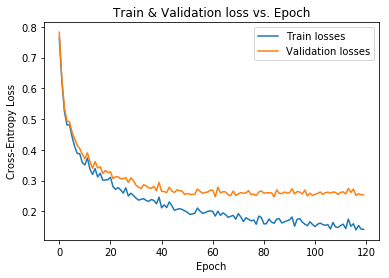

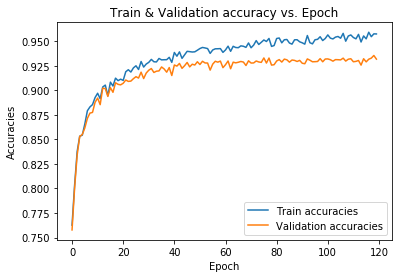

In [41]:
def test4():
  config = custom_config_from_part_c({
    'batch_size': 1000,
    'learning_rate': 0.0007,
    'epochs': 120
  })
  report = evaluate_model(config)
  train_report = report['train_report']
  plot_from_train_report(train_report)
test4()